Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

In [1]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}")


DOLFINx version: 0.8.0


1: Total tims is  48.05 s
2: Total numb steps is  62


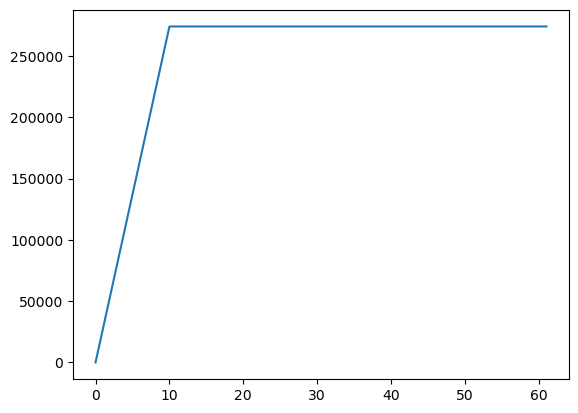

In [2]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (
    LinearProblem,
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc,
)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (
    Constant,
    dirichletbc,
    Function,
    FunctionSpace,
    form,
    locate_dofs_topological,
)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    dx,
    grad,
    inner,
    Measure,
    dot,
    FacetNormal,
)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# import own functions


# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 20
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 2240
v_vehicle = 160
c_acc = 1

def vehicle_initial(angular_r, v_vehicle, c_contact, c_acc):
    import numpy as np
    v_ini = v_vehicle/3.6   /   (920/2/1000) 
    # D_wheel = 920 mm, v = D_wheel /2 /1000 * v_ini *3.6   # km/h
    # Start time, Final time  
    t = 0
    t_brake = 49
    t_lag = 4
    # rubbing element radius, Contact area 
    r_rub = 18.8
    S_rub_circle = r_rub**2 * c_contact
    S_total = S_rub_circle * np.pi * 18  #mm2
    # initial and brake pad temperature
    Ti = 60
    Tm = 60
    # density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
    t_u = 1e3 # m to mm
    rho = 7850 /(t_u**3)
    c = 462
    k = 48 / t_u
    # mu, P_brake,  r_disc , heat_distribution  
    mu = 0.376
    P_initial = 274000
    r_disc = 0.25
    heat_distribution = 0.88
    # calculate total num_steps
    if c_acc == 1:  # constant acc for the whole process
        acc = v_ini/t_brake
        v_lag_end = (v_ini - (acc *t_lag) )   
        angular_r_rad = angular_r/180*np.pi  
        dt_lag = angular_r_rad  /  ( ( v_ini + v_lag_end  ) /2 )
        n_lag = round (t_lag / dt_lag) + 1 
        dt_a_lag = angular_r_rad  /  ( v_lag_end /2 )
        n_a_lag =  round ( (t_brake - t_lag) / dt_a_lag ) + 1
        num_steps = n_lag + n_a_lag
        dt = []
        v_angular = [v_ini]
        for i in range(num_steps):
            dt.append ( angular_r_rad / v_angular[i] )
            v_angular.append (  v_ini- sum(dt) * acc )           
        P = []
        for i in range(num_steps):
            if i <= n_lag:
                P.append( P_initial/ n_lag * (i ** (1)) )
            else:
                P.append( P_initial) 
    # S_or is the original brake pad rubbing area, 200 cm2. 
    S_or = 200
    S_new = S_total/100 #mm2 to cm2
    # g is the heat source,unit is w/mm2 
    g = []
    for i in range(num_steps):
        g.append ( mu * P[i] * v_angular[i] * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) )
        
    #  h is the heat convection coefficient, unit is W/mm2 K  
    h = 7.75e-5
    # radiation is the radiation heat coefficient, unit is W/mm2 K
    # stefan-Boltzmann constant theta = 5.67*10e-8 w/m2 k-4,   0.64 is the emmissivity
    radiation = 5.670*(10e-8)/(t_u**2)  * 0.64

    return dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c,k,t_brake,S_total
    
# calling local functions to get all parameters
(   dt,  P,    g,    num_steps,    h,    radiation,    v_angular,    Ti,    Tm,    S_rub_circle,    t,
    rho,    c,    k,    t_brake,    S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)



plt.plot(P)



In [3]:
from disc_f import *

## 2: Mesh

In [4]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2,'tetra')
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, CG is Lagrabge
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V, DG is discontinuous Lagrange
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 100))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-20.msh' exists, start creat now:
Info    : Reading 'm-3-20.msh'...
Info    : 168 entities
Info    : 2532 nodes
Info    : 8476 elements
Info    : Done reading 'm-3-20.msh'



## 3: Setup 


In [5]:
# create xdmf file, for paraview
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition
x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [6]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = trial function, solution what we want to know
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (
    (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u), grad(v)) * dx
    + h * inner(u, v) * ds(200)
    + radiation * inner(u**4, v) * ds(200)
    - (
        inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)
    )
)


for i in list(range(1, 19)):

    ## new start 2024/5/16, friction points do not have convection heat + heat input
    F += ( 
          + inner(g[0], v) * ds(10 * i) 
          - h * inner( u, v) * ds(10 * i)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * i) 
         )

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 600],
)

2024-11-18 13:11:43.164 (   4.551s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:43.188 (   4.574s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:43.194 (   4.580s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00665958 (tol = 1e-10) r (rel) = 2.20572e-06(tol = 1e-06)
2024-11-18 13:11:43.201 (   4.587s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:43.214 (   4.599s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.66733e-08 (tol = 1e-10) r (rel) = 1.21466e-11(tol = 1e-06)
2024-11-18 13:11:43.217 (   4.602s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.


## 5: Solution


In [10]:
print(S_rub_circle)

353.44000000000005


In [7]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

num_steps = int(10)
for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(domain, x_co, y_co, S_rub_circle )
    
    facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3] )
    
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u), grad(v)) * dx
        + h * inner(u, v) * ds(200)
        + radiation * inner(u**4, v) * ds(200)
        - (
            inner(f, v) * dx
            + (rho * c) / dt[i] * inner(u_n, v) * dx
            + h * Tm * v * ds(200)
            + radiation * (Tm**4) * v * ds(200)
        )
    )

    for j in list(range(1, 19)):
       
        F += ( 
          - inner(g[i], v) * ds(10 * j) 
          - h * inner( u, v) * ds(10 * j)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) 
         )

        

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 2240 degree. 2: Current time is 0.4 s. 3: Completion is 0.8 %. 

2024-11-18 13:11:46.426 (   7.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:46.426 (   7.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:46.426 (   7.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-11-18 13:11:46.427 (   7.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:46.427 (   7.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:46.427 (   7.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-11-18 13:11:46.427 (   7.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:46.427 (   7.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.8 %. 

2024-11-18 13:11:47.454 (   8.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:47.454 (   8.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:47.456 (   8.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:47.456 (   8.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:47.456 (   8.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:47.469 (   8.854s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:47.492 (   8.878s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:47.507 (   8.893s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4480 degree. 2: Current time is 0.8 s. 3: Completion is 1.7 %. 

2024-11-18 13:11:47.712 (   9.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:47.712 (   9.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:47.712 (   9.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-11-18 13:11:47.713 (   9.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:47.713 (   9.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:47.713 (   9.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-11-18 13:11:47.713 (   9.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-11-18 13:11:47.713 (   9.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 6720 degree. 2: Current time is 1.2 s. 3: Completion is 2.5 %. 

2024-11-18 13:11:48.859 (  10.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:48.859 (  10.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:48.859 (  10.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:48.859 (  10.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:48.860 (  10.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:48.863 (  10.249s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:48.871 (  10.256s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:48.885 (  10.272s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8960 degree. 2: Current time is 1.6 s. 3: Completion is 3.3 %. 

2024-11-18 13:11:49.881 (  11.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:49.881 (  11.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:49.882 (  11.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:49.882 (  11.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:49.882 (  11.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:49.886 (  11.271s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:49.898 (  11.283s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:49.914 (  11.299s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11200 degree. 2: Current time is 2.1 s. 3: Completion is 4.2 %. 

2024-11-18 13:11:50.881 (  12.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:50.881 (  12.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:50.882 (  12.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:50.882 (  12.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:50.882 (  12.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:50.884 (  12.270s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:50.899 (  12.285s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:50.916 (  12.301s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13440 degree. 2: Current time is 2.5 s. 3: Completion is 5.1 %. 

2024-11-18 13:11:51.890 (  13.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:51.890 (  13.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:51.890 (  13.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:51.890 (  13.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:51.891 (  13.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:51.894 (  13.280s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:51.908 (  13.294s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:51.923 (  13.309s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15680 degree. 2: Current time is 2.9 s. 3: Completion is 5.9 %. 

2024-11-18 13:11:52.888 (  14.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:52.888 (  14.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:52.889 (  14.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:52.889 (  14.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:52.889 (  14.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:52.895 (  14.280s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:52.906 (  14.291s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:52.920 (  14.305s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17920 degree. 2: Current time is 3.3 s. 3: Completion is 6.8 %. 

2024-11-18 13:11:53.879 (  15.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:53.879 (  15.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:53.879 (  15.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:53.879 (  15.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:53.881 (  15.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:53.886 (  15.271s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:53.900 (  15.286s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:53.927 (  15.312s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20160 degree. 2: Current time is 3.8 s. 3: Completion is 7.7 %. 

2024-11-18 13:11:54.882 (  16.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:54.883 (  16.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:54.887 (  16.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:54.887 (  16.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:54.890 (  16.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:54.895 (  16.281s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:54.906 (  16.291s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:54.930 (  16.316s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22400 degree. 2: Current time is 4.2 s. 3: Completion is 8.6 %. 

2024-11-18 13:11:55.912 (  17.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:55.932 (  17.317s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:55.936 (  17.322s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.033348 (tol = 1e-10) r (rel) = 4.55595e-05(tol = 1e-06)
2024-11-18 13:11:55.941 (  17.326s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:55.944 (  17.330s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.07379e-07 (tol = 1e-10) r (rel) = 1.46699e-10(tol = 1e-06)
2024-11-18 13:11:55.946 (  17.331s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-11-18 13:11:55.946 (  17.331s) [main            ]      xdmf_functi

1: Completion is 8.6 %. 

2024-11-18 13:11:56.896 (  18.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:56.896 (  18.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-11-18 13:11:56.897 (  18.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-11-18 13:11:56.901 (  18.286s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-11-18 13:11:56.911 (  18.297s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:56.934 (  18.319s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-11-18 13:11:56.938 (  18.323s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00678508 (tol = 1e-10) r (rel) = 2.36739e-05(tol = 1e-06)
2024-11-18 13:11:56.943 (  18.329s


t and T have been successfully saved as Result_T-s-10-d-2240-m-3-20-c-1-e-8476.csv


# 6: Post process

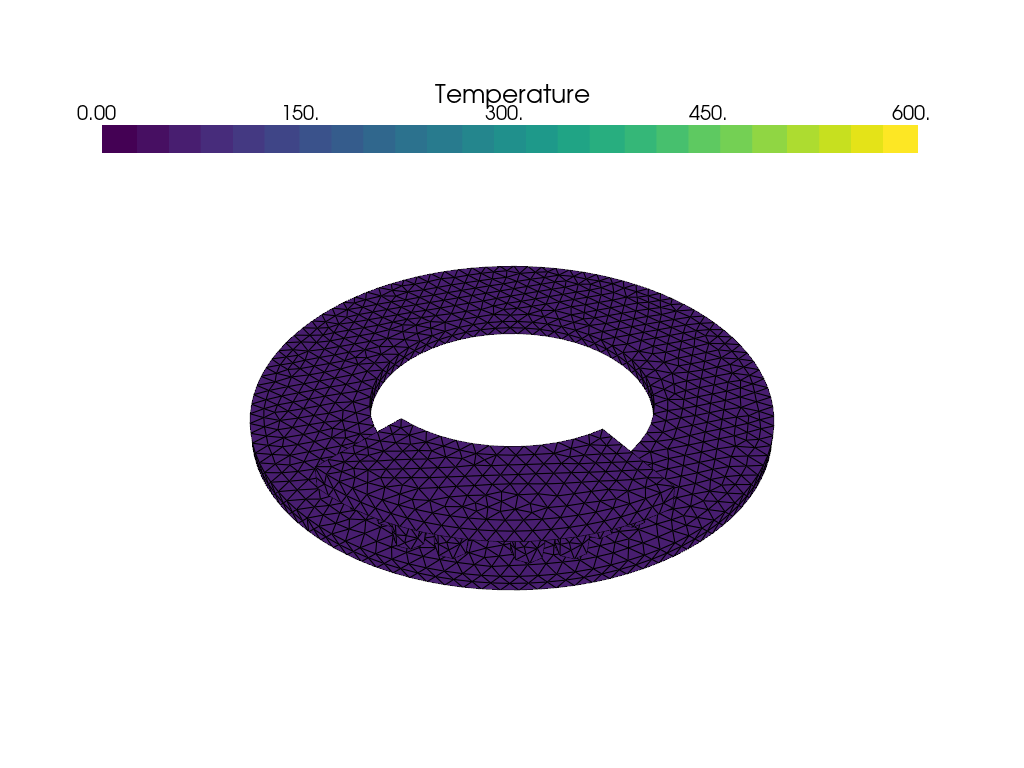

1: Start at: 2024-11-18 13:11:39
2: End at: 2024-11-18 13:11:57
3: Simulation time is 19.0 second
4: First time step dt is 0.40464 s
5: Convection heat transfer coefficient is 7.75e-05 W/mm2 K
6: Radiation is 3.6e-13 W/mm2 K-4
7: Each rotation degree is 2240 per time step or 6.2 circle
8: The first rotation degree is 9773.8
9: The mid rotation degree is 13363.6
10: The last rotation degree is 89299.2
11: Total contact area of 18 rubbing element is 199.9 cm2
12: The mesh element size is between 3-20 mm
13: Total elements number is 8476



In [8]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
        min = elapsed_time1 / 60
        hours = min / 60
        file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
        file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Practice/Concise"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results/python_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
#files_to_move = [gif_name, h5_name, xdmf_name, txt_name, csv_name]
# Move each file to the destination directory
#for filename in files_to_move:
#    source_file_path = os.path.join(source_dir, filename)
#    destination_file_path = os.path.join(destination_dir, filename)
    #shutil.move(source_file_path, destination_file_path)
#print("Move files successfully")

Lables already exists, for mesh m-3-20.msh is  [1713, 1587, 708]


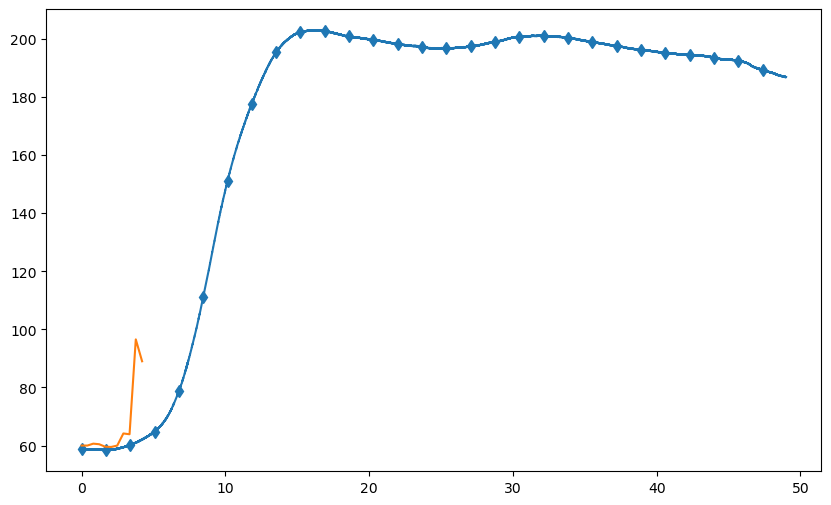

In [9]:
from disc_f import *
import pandas as pd
plt.figure(figsize=(10, 6))

df1 = pd.read_csv('/home/yanjun/documents/sim_results/experiment_result.csv')
T_e_ave = ( df1.iloc[:,1] + df1.iloc[:,3] + df1.iloc[:,5] ) /3
t_e = np.linspace (0, 49, len(T_e_ave) )
plt.plot(t_e, T_e_ave, label= "Experiment",marker='d',markevery=1000)


lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)

plt.plot(t, T_3_ave)